# Predicting Housing Costs

In [112]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import random
from collections import Counter
from IPython.core.display import HTML
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
import statsmodels.formula.api as smf
import time
import re 

%matplotlib inline

In [122]:
import numpy as np
import pandas as pd
import codecs
import matplotlib.pyplot as plt
import seaborn as sns
import re
%matplotlib inline

In [110]:
housing = pd.read_csv('C:\Code\Data\melbourne.csv')


In [111]:
housing = housing.dropna()
print(housing.shape)
display(housing.head())

(8887, 21)


,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
2,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,...,1.0,0.0,156.0,79.0,1900.0,Yarra City Council,-37.8079,144.9934,Northern Metropolitan,4019.0
4,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,...,2.0,0.0,134.0,150.0,1900.0,Yarra City Council,-37.8093,144.9944,Northern Metropolitan,4019.0
6,Abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,4/06/2016,2.5,3067.0,...,1.0,2.0,120.0,142.0,2014.0,Yarra City Council,-37.8072,144.9941,Northern Metropolitan,4019.0
11,Abbotsford,124 Yarra St,3,h,1876000.0,S,Nelson,7/05/2016,2.5,3067.0,...,2.0,0.0,245.0,210.0,1910.0,Yarra City Council,-37.8024,144.9993,Northern Metropolitan,4019.0
14,Abbotsford,98 Charles St,2,h,1636000.0,S,Nelson,8/10/2016,2.5,3067.0,...,1.0,2.0,256.0,107.0,1890.0,Yarra City Council,-37.8060,144.9954,Northern Metropolitan,4019.0


Data is too large for more complex models, I can only model party of it. 

In [39]:
trainlen = int(len(housing['Price'])/2)
housingt = housing.iloc[:4000, :]

Decision Tree

In [33]:
from sklearn import tree
start_time = time.time()
# Initialize and train our tree.
decision_tree = tree.DecisionTreeRegressor(
    max_features=2,
    max_depth=4,
)
X = housingt.drop(housingt[['Price','SellerG','Address','Lattitude','Longtitude','Propertycount','Distance']], 1)
Y = housingt['Price']
X = pd.get_dummies(X)
decision_tree.fit(X, Y)
print(decision_tree.score(X,Y))
print("\nRuntime: --- %s seconds ---" % (time.time() - start_time))

0.27669842203834233

Runtime: --- 0.014957427978515625 seconds ---


In [60]:
from sklearn import ensemble
from sklearn.model_selection import cross_val_score
import time
start_time = time.time()
rfr = ensemble.RandomForestRegressor(max_features=15)
X = housingt.drop(housingt[['Price','SellerG','Address','Lattitude','Longtitude','Propertycount','Distance']], 1)
Y = housingt['Price']
X = pd.get_dummies(X)
rfr.fit(X,Y)

print(rfr.score(X,Y))
score_ols = cross_val_score(rfr, X, Y, cv=10)
print("\nError: %0.2f (+/- %0.2f)" % (score_ols.mean(), score_ols.std() * 2))
print("\nRuntime: --- %s seconds ---" % (time.time() - start_time))

0.9607089659056527

Error: 0.70 (+/- 0.11)

Runtime: --- 1.137601613998413 seconds ---


In [44]:
start_time = time.time()
gbr = ensemble.GradientBoostingRegressor()
gbr.fit(X,Y)

print(gbr.score(X,Y))
score_ols = cross_val_score(gbr, X, Y, cv=10)
print("\nError: %0.2f (+/- %0.2f)" % (score_ols.mean(), score_ols.std() * 2))
print("\nRuntime: --- %s seconds ---" % (time.time() - start_time))

0.8821017628172924

Error: 0.76 (+/- 0.13)

Runtime: --- 19.534478187561035 seconds ---


The random forest regressor seems to be function much better with the data that the boosted decision tree, so  will continue forward with it.

In [ ]:
rfr.

In [61]:
rfr.feature_importances_

array([7.78784255e-02, 6.10797305e-02, 1.21885883e-01, 8.79672709e-02,
       2.83398964e-02, 6.53817610e-02, 9.64327084e-02, 6.78685290e-02,
       1.42941416e-04, 8.08209577e-04, 3.02427480e-04, 3.95900123e-03,
       5.71149964e-05, 3.48223983e-04, 1.13863753e-04, 4.09440078e-05,
       3.10606290e-03, 3.94971667e-04, 3.99570729e-04, 5.70590508e-04,
       2.08495259e-04, 6.03320190e-05, 3.00978735e-03, 1.72005114e-03,
       1.28707926e-05, 4.06301938e-04, 2.80543284e-03, 8.78024050e-04,
       2.30506482e-04, 4.17136647e-03, 6.21201581e-04, 1.12664582e-06,
       9.14700342e-04, 3.24064510e-04, 1.88370236e-04, 1.57981098e-04,
       1.26649119e-05, 3.31792546e-04, 4.77929767e-03, 1.81877283e-03,
       1.58433284e-04, 1.22334545e-03, 3.03930424e-04, 2.08517006e-04,
       4.18851065e-06, 1.52858526e-04, 3.73276529e-04, 2.13160088e-04,
       6.99660301e-04, 5.30947673e-04, 2.49821645e-04, 3.17655313e-04,
       1.13397778e-04, 3.31730243e-04, 9.27535697e-04, 2.82076550e-04,
      

In [55]:
rfr.n_features_

217

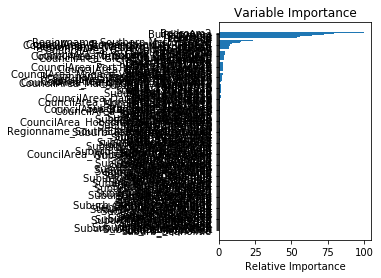

In [63]:
feature_importance = rfr.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [139]:
features = X.columns[sorted_idx]

In [147]:
features = pd.array(features)

AttributeError: module 'pandas' has no attribute 'array'

In [1]:
hey = 'absdjnHEYcmdkcndk'
hey.replace('[A-Z]','b')

'absdjnHEYcmdkcndk'

In [127]:
re.split('[A-Z]',hey)

['absdjn', '', '', 'cmdkcndk']

In [142]:
re.sub('[A-Z]','',hey)

'absdjncmdkcndk'

In [145]:
for f in features:
    f = re.sub('[A-Z]','',f)
features

Index(['Suburb_Seaholme', 'Suburb_Ripponlea', 'Suburb_Brooklyn',
       'Suburb_Caulfield East', 'Suburb_Williamstown North',
       'Suburb_Essendon North', 'Suburb_Melbourne', 'Suburb_Burnley',
       'Suburb_Bellfield', 'Suburb_Southbank',
       ...
       'Car', 'Regionname_Southern Metropolitan', 'Type_h', 'Postcode',
       'Landsize', 'YearBuilt', 'Rooms', 'Bathroom', 'BuildingArea',
       'Bedroom2'],
      dtype='object', length=216)

In [105]:
features = [s.replace('_','') for s in features]
features

['SuburbSeaholme',
 'SuburbRipponlea',
 'SuburbBrooklyn',
 'SuburbCaulfield East',
 'SuburbWilliamstown North',
 'SuburbEssendon North',
 'SuburbMelbourne',
 'SuburbBurnley',
 'SuburbBellfield',
 'SuburbSouthbank',
 'SuburbWatsonia',
 'Date29/04/2017',
 'SuburbSouth Kingsville',
 'SuburbEssendon West',
 'Date8/04/2017',
 'SuburbAltona North',
 'SuburbPrinces Hill',
 'SuburbSpotswood',
 'SuburbMaidstone',
 'SuburbKingsville',
 'SuburbOak Park',
 'SuburbJacana',
 'SuburbHampton East',
 'SuburbAlbion',
 'SuburbWest Melbourne',
 'SuburbBalaclava',
 'SuburbOakleigh South',
 'SuburbGlen Huntly',
 'SuburbKeilor Park',
 'SuburbStrathmore Heights',
 'SuburbFlemington',
 'SuburbKingsbury',
 'SuburbStrathmore',
 'SuburbCremorne',
 'SuburbAltona',
 'SuburbGowanbrae',
 'Date4/02/2016',
 'SuburbNiddrie',
 'SuburbAbbotsford',
 'SuburbTravancore',
 'SuburbHeidelberg West',
 'SuburbYallambie',
 'SuburbCaulfield North',
 'SuburbHeidelberg',
 'SuburbKeilor East',
 'SuburbBulleen',
 'SuburbCarlton',
 'Sub